## Load Contextual Plus Streams and do text searches

In [92]:
import os, sys, gzip, json, pprint, pymongo, pandas as pd
from datetime import datetime
%matplotlib inline

In [93]:
EVENTS = {
#     'harvey'      : '/data/chime/Hurricanes_HIM/contextual-plus/OfficialSources_HIM/GNIP/', #HarveyIrma CP
#     'matthew'     : '/data/chime/matthew/gnip/',              # This is all keyword collection from Matthew
#     'matthew-geo' : '/data/chime/matthew/gnip-geo/all/' # This is all tweets from within the windswath of Matthew
    'harvey_kw' : '/data/chime/Hurricanes_HIM/keyword/harvey/GNIP/',
    'sandy'  : '/data/chime/sandy_tweets_gnip_simple.jsonl'
}

START_DATES = {
    'sandy': datetime(2012,10,22,0,0,0),
    'harvey_kw': datetime(2017,8,17,0,0,0)
}

END_DATES = {
    'sandy': datetime(2012,10,31,0,0,0),
    'harvey_kw': datetime(2017,8,27,0,0,0)
}

In [94]:
def simplify_tweet(t):
    '''Simplify tweet to only specified attributes (e.g. id, text, date, user attributes, etc.)'''
    new_tweet = {'id':t['id'].split(':')[2],
                 'text':t['body'].replace("\n"," ").replace("\r"," ").replace("\t"," "),
                 'created_at':datetime.strptime(t['postedTime'], "%Y-%m-%dT%H:%M:%S.%fZ"),
                 'user':t['actor']['preferredUsername'].replace("\t"," "),
                 'verb':t['verb']
                }        
    return(new_tweet)

In [95]:
def gzip_to_full_tweet(file, event):
    tweets          = []
    tweet_count     = 0
    error_count     = 0
    info = None
    rt_count = 0
    
    with gzip.open(file, 'rb') as f:
        file_content = f.read()
        
        for idx, line in enumerate(file_content.decode().split("\n")):
            tweet_count += 1
            try:
                t = json.loads(line.strip())
            except json.JSONDecodeError:
                if(line==""):
                    pass
                
            if 'info' in t:
                info = t
            else:
                if t['verb'] != 'share':
                    t = simplify_tweet(t)
                    if t['created_at'] > START_DATES[event] and t['created_at'] < END_DATES[event]:
                        tweets.append(t)
                else:
                    rt_count+=1

            if idx%1000==0:
                sys.stderr.write("\r{0} tweets parsed      ".format(tweet_count))
#     sys.stderr.write("\r{0} tweets parsed     ".format(tweet_count))
    return tweets, info, rt_count

In [113]:
def load_jsonl(file):
    t_count = 0
    rt_count = 0
    tweet_array = []

    with open(file,'r') as inFile:
        for line in inFile:
            t = json.loads(line)
            if t['verb'] != 'share':
                t['created_at'] = datetime.strptime(t['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")
                tweet_array.append(t)
                t_count += 1
                if t_count%10000==0:
                    sys.stderr.write("\r"+" Loaded {0} tweets, skipped {1} retweets".format(t_count, rt_count))
            else: 
                rt_count += 1
    return tweet_array

In [114]:
def get_tweets(event, limit=None):
    gnip_files = os.listdir( EVENTS[event] )
    print("Found {0} GNIP files, limit: {1}".format(len(gnip_files), limit))
    
    t_count = 0
    rt_count_total = 0
    tweet_array = []
    for idx, file in enumerate(gnip_files[:limit]):
        parts = file.split("_")
        file_date = datetime(int(parts[1]), int(parts[2]), int(parts[3]), int(parts[4]), int(parts[5]),0)
        if file_date < START_DATES[event] or file_date > END_DATES[event]:
            continue
        
        tweets, info, rt_count = gzip_to_full_tweet(EVENTS[event] +file, event)
        t_count += info['info']['activity_count']
        tweet_array += tweets
        rt_count_total += rt_count
        if idx%2==0:
            sys.stderr.write("\r"+" "*80 + "{0} files; {1} tweets".format(idx+1, t_count))
    print("{0} files processed with {1} tweets, skipped {2} retweets".format(idx+1, t_count, rt_count_total))
    return tweet_array

# Step 1: Load Tweets

### Sandy Keyword Tweets

In [115]:
sandy_tweets = load_jsonl(EVENTS['sandy'])

 Loaded 4840000 tweets, skipped 4175875 retweets

In [ ]:
SANDY = pd.DataFrame(sandy_tweets)
SANDY['date'] = SANDY.created_at.apply(lambda x: x.date())
print("Tweets: {0}".format(len(SANDY)))
SANDY.head()

Tweets: 4847095


,created_at,id,text,user,verb,date
0,2012-10-24 23:58:06,261255274801815552,New 8PM update from the National Hurricane Cen...,MikeMasco,post,2012-10-24
1,2012-10-24 23:58:07,261255282758402048,Prayers over Jamaica.As Hurricane Sandy approa...,KaiyaNichole,post,2012-10-24
2,2012-10-24 23:58:07,261255281726603266,That T.S turned into a Hurricane in A Few hour...,DJ_BMONEY,post,2012-10-24
3,2012-10-24 23:58:09,261255287581843457,All the news of Hurricane Sandy has left Sandy...,littleritzz,post,2012-10-24
4,2012-10-24 23:58:14,261255312147881985,@mooremayhem IS A YAAD TING when we get RASS ...,WiggiLeaks,post,2012-10-24


### Harvey Keyword Tweets

In [ ]:
harvey_tweets = get_tweets('harvey_kw')

Found 3456 GNIP files, limit: None


4001 tweets parsed                                                              557 files; 1140231 tweets

In [ ]:
HARVEY = pd.DataFrame(harvey_tweets)
HARVEY['date'] = HARVEY.created_at.apply(lambda x: x.date())
print("Tweets: {0}".format(len(HARVEY)))
HARVEY.head()

# Some DataFrame Analysis

In [ ]:
SANDY_WORDS  = ['flooded','sandy','evacuate','electricity','shelter','destroy','generators','light','power','emergency ','candles','flashlights','decisions','disaster','forecast','wind','repair','scary','heat','school ','worried ','response','hospital','rising','substations','government','meetings','population','resources','mayor','receding','relatives','supplies','leaders','looting','transportation','waves','fires','rain','abandoned','devastated','drowned','ocean','raised','rescue','safe','stuck','suffering','survivied','afraid','bridge','designated','impact','neighborhood','rebuild','scared','telephone','twitter','dangerous','federal','firefighters','floated','grid','risk','scientist','terrible','tornado','trouble','administration','announce','authorities','bags','bathtubs','batteries','dumping','fuel','pouring','residents','roof','ambulences','canal','coastal','death','died','donate','garbage','governer','infrastructure','facebook','media','paper','television','computer','cell','internet']
HARVEY_WORDS = ['water','helps','community','storm','call','prepared','hurricane','rains','stay','phone','talking','evacuate','homes','news','leave','rescue','tornado','boat','family','church','neighbor','media','fema','bayou','warnings','facebook','weather','emergency','lights','radio','plans','money','power','channel','wind','damage','forecast','decision','shelter','devastation','alerts','gulf','police','rita','cell','lake','seniors','rising','stuck','drain','electricity','drainage','governments','safe','decide','higher','officials','afraid','danger','katrina','mayor','rainfall','surge','trapped','deep','disabled','leaders','strong','bayous','blessed','hospital','praying','frustrating','mexican','risk','river','univision','generator','safety','tide','agency','disaster','faith','mandatory','medicine','reservoirs','hotel','levies','pets','stranded','underwater']

In [ ]:
SANDY['keywords']  = SANDY.text.apply(lambda text: pd.Series([x in text.lower() for x in SANDY_WORDS]).any())
HARVEY['keywords'] = HARVEY.text.apply(lambda text: pd.Series([x in text.lower() for x in HARVEY_WORDS]).any())

In [ ]:
SANDY.head()

In [ ]:
HARVEY.head()

### Secondary Search Words

In [ ]:
SOCIAL_NETWORKS = ['help','mother','father','brother','sister','grandmother','grandfather','neighbor ','friend','community','church','school ','pastor','principal','kids','cousin','neice ','nephew','son ','daughter','aunt','uncle','teacher','neighborhood','children','manager','stuck','aid','assist','grandma','grandpa','family']
FORECAST_INFO   = ['flood','rain','surge','wind','water','cone','dirty side','clean side','uncertainty','intensify','landfall','category','forecast','pressure','hurricane','trajectory','tropical','disturbance','depression','tv','radio','internet','paper']
PROTECTIVE_DECISIONS = ['stay','leave','shelter','ride','evacuate','roof','higher','attic','get out','rob','theives','pet','dog','cat','motel','hotel','traffic','highway','road','vacancy','go','shutters','elevator','power','electricity','order','mayor','car','subway','bus','basement','last time','shelter']
MATERIAL_NEEDS = ['stay','leave','shelter','ride','evacuate','roof','higher','attic','get out','rob','theives','pet','dog','cat','motel','hotel','traffic','highway','road','vacancy','go','shutters','elevator','power','electricity','order','mayor','car','subway','bus','basement','last time','shelter']
BEAUROCRATIC_ASSISTANCE = ['papers','fema','red cross','city','Super neighborhood','county','emergency manager','police','fire']

In [ ]:
def second_level_search(df):
    df['SOCIAL_NETWORKS'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in SOCIAL_NETWORKS]).any())
    df['FORECAST_INFO'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in FORECAST_INFO]).any())
    df['PROTECTIVE_DECISIONS'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in PROTECTIVE_DECISIONS]).any())
    df['MATERIAL_NEEDS'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in MATERIAL_NEEDS]).any())
    df['BEAUROCRATIC_ASSISTANCE'] = df.text.apply(lambda text: pd.Series([x in text.lower() for x in BEAUROCRATIC_ASSISTANCE]).any())    

In [ ]:
second_level_search(SANDY)
second_level_search(HARVEY)

In [ ]:
SANDY.head()

In [ ]:
HARVEY.head()

<hr>
<br>
# Group the dataframes by user and get counts for tweets within the second level filtering

In [270]:
HARVEY_gb_user = df.groupby('user')

Going into the secondary filtering, this is what it looks like: 
len(HARVEY_92_USERS_SN),len(HARVEY_92_USERS_DM),len(HARVEY_92_USERS_AC)
(60699, 104374, 56593)

In [296]:
THRESHOLD = 10;
HARVEY_92_USERS_SN = []
HARVEY_92_USERS_DM = []
HARVEY_92_USERS_AC = []
for user, tweets in HARVEY_gb_user:
    if tweets.harvey92.any():
        if tweets.SOCIAL_NETWORKS.sum() > THRESHOLD:
            HARVEY_92_USERS_SN.append( (user, tweets.SOCIAL_NETWORKS.sum() ) )
        if tweets.DECISION_MAKING.sum() > THRESHOLD:
            HARVEY_92_USERS_DM.append( (user, tweets.DECISION_MAKING.sum() ) )
        if tweets.ADAPTIVE_CAPACITY.sum() > THRESHOLD:
            HARVEY_92_USERS_AC.append( (user, tweets.ADAPTIVE_CAPACITY.sum() ) )

In [299]:
len(HARVEY_92_USERS_SN),len(HARVEY_92_USERS_DM),len(HARVEY_92_USERS_AC)

(1105, 3199, 993)

In [308]:
HARVEY_92_USERS_AC[5:10]

[('2015gardener', 12),
 ('3ghero', 16),
 ('3monarchs', 12),
 ('4361a4be893d4c0', 35),
 ('52052c3827724b6', 12)]

In [309]:
HARVEY_gb_user.get_group('2015gardener').text.values

array(['@CNN Cant we quit this already?', '@CNN Ha Ha Ha Ha !',
       '@marcorubio Oh its true LITTLE MARCO! Yep thats who you are! Repubs are the biggest disappontment of my life! GOD BLESS POTUS!',
       '@CNN @FareedZakaria I am so proud that Iran is no longer happy with America that means we are finally standing up to these killers!',
       '@CNN Rush to Congress have them get a lawful way for you Welcome DACA enjoy living by the laws America first!',
       '@CNN So elitist so ignorant  WHO ARE THEY HURTING seems it was never about helping after all ONLY ATTENTION! God sees hypocrites!',
       '@CNN You hate spewers you Fake News you resist promoters! Just arm of hatred!',
       '@CNN CNN its all about themselves! Tune out turn off these hateful lefties have nothing but talking points from the dems!',
       '@CNN Watch the whole chase I see why a jury decided this life is a messy business why we need to listen',
       '@CNN Ridiculous &amp; please where are the Obama colleg

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee7b96c9b0>]],
      dtype=object)

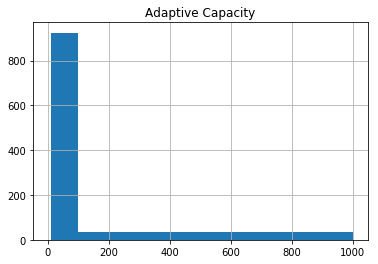

In [297]:
pd.DataFrame({'Adaptive Capacity' : [x[1] for x in HARVEY_92_USERS_AC]}).hist(bins=[1,2,3,4,5,6,7,8,10,100,200,1000])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee76d811d0>]],
      dtype=object)

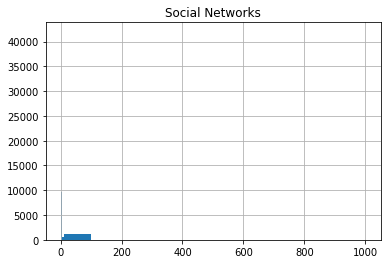

In [294]:
pd.DataFrame({'Social Networks' : [x[1] for x in HARVEY_92_USERS_SN]}).hist(bins=[1,2,3,4,5,6,7,8,10,100,200,1000])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee76031a90>]],
      dtype=object)

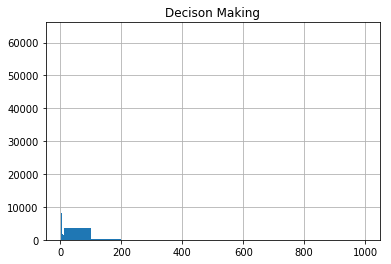

In [295]:
pd.DataFrame({'Decison Making' : [x[1] for x in HARVEY_92_USERS_DM]}).hist(bins=[1,2,3,4,5,6,7,8,10,100,200,1000])

# Now for Matthew

In [195]:
matthew = pd.DataFrame(TWEETS)
matthew['date'] = matthew.created_at.apply(lambda x: x.date())
print(len(df))

1910995


In [196]:
matthew.head()

,created_at,id,text,user,verb,date
0,2016-08-26 16:02:24,769203351401689088,"I'm at Kebab Café in Fort-de-France, Martiniqu...",Ced_BM,post,2016-08-26
1,2016-08-26 16:02:08,769203282514440193,I don't want Hollywood I want Forbes. #positiv...,greggar_d,post,2016-08-26
2,2016-08-26 16:04:23,769203849420738561,If Martinique nice one more time will have to ...,FRASTWINZMUSIC,post,2016-08-26
3,2016-08-26 16:06:31,769204385910063104,I'm at Chez Moi 😼 https://t.co/ocTN8osd3h,Amigo_stn,post,2016-08-26
4,2016-08-26 16:09:04,769205026858336256,Happy birthday to KING Valmix 👑 @djvalmix #la...,ZoekikiAyiti,post,2016-08-26


In [197]:
MATTHEW_WORDS_160 = ['storm','flooding','house','waters','surge','evacuate','hurricane','information','rains','country','community','level','leave','island','news','weather','coast','moving','damage','risk','forecast','neighborhood','power','rising','zone','media','decision','preparing','hotel','marsh','drain','river','emergency','mandatory','scary','wind','government','tidal','tornado','worst','raise','coastal','events','fema','highest','scare','service','block','drainage','causeway','bottom','hill','katrina','traffic','urgency','management','neighbor','worried','hospital','television','tropical','voluntary','warning','alert','barrier','broadcasting','danger','generators','landmark','newspaper','ocean','climate','computer','disability','nature','parents','plain','radar','roof','sand','underwater','channel','disaster','lower','meetings','notice','pollution',' telephone','together','afraid','approaching','electricity','guard','meteorologist','reporting','survive','warming',' wave','commissioners','connect','country','dark','deep','engineering','gulf','lake','message','patients','responsibility','roots','animals','citizens','depot','devastating','died','dogs','drove','environment','googling','intertidal','landscape','nursing','panic','police','pump','repaired','resources','respect','sewer','siren','soaked','source','spread','stuck','tributaries','washed','website','announcements','authority','break','buses','cellphone','cuts','debris','disadvantage','downstream','extreme','fire','food','foundation','hazard','marshside','recovery','shaking','swept','terrible','shelter','threat','trouble','uncertainty']
MATTHEW_WORDS_95  = ['storm','flooding','house','waters','surge','evacuate','hurricane','information','rains','community','leave','maps','island','news','weather','coast','damage','risk','forecast','power','rising','media','decision','preparing','emergency','mandatory','scary','wind','government','tidal','tornado','coastal','fema','scare',' service','drainage','causway','katrina','traffic','urgency','managment','mother','nieghbor','hospital','television','tropical','volutary','warning','alert','broadcasting','danger','generators','landmark','newspaper','climate',' computer','parents','radar','roof','underwater','airport','disaster','pollution','telephone','afraid','appraoching','electricity','meteorologist','survive',' wave','commissioners','gulf','devastating','died','environmet','googling','intertidal','panic','police','resources','siren','soaked','stuck','website','announcements','authority','buses',' cellphone',' debris','extreme','fire','hazard','recovery','terrible','shelter']

In [198]:
matthew['matthew160'] = matthew.text.apply(lambda text: pd.Series([x in text for x in MATTHEW_WORDS_160]).any())
matthew['matthew92']  = matthew.text.apply(lambda text: pd.Series([x in text for x in MATTHEW_WORDS_95]).any())

In [200]:
matthew.head()

,created_at,id,text,user,verb,date,matthew160,matthew92
0,2016-08-26 16:02:24,769203351401689088,"I'm at Kebab Café in Fort-de-France, Martiniqu...",Ced_BM,post,2016-08-26,False,False
1,2016-08-26 16:02:08,769203282514440193,I don't want Hollywood I want Forbes. #positiv...,greggar_d,post,2016-08-26,True,True
2,2016-08-26 16:04:23,769203849420738561,If Martinique nice one more time will have to ...,FRASTWINZMUSIC,post,2016-08-26,False,False
3,2016-08-26 16:06:31,769204385910063104,I'm at Chez Moi 😼 https://t.co/ocTN8osd3h,Amigo_stn,post,2016-08-26,False,False
4,2016-08-26 16:09:04,769205026858336256,Happy birthday to KING Valmix 👑 @djvalmix #la...,ZoekikiAyiti,post,2016-08-26,False,False


In [218]:
print("All Tweets: {0} | Users: {1}".format(len(matthew), matthew.user.nunique()))
print("Tweets in the Matthew 160 Collection: ", len(matthew.query('matthew160')))
print("Users in the Matthew 160 Collection: ", matthew.query('matthew160').user.nunique())

All Tweets: 3434483 | Users: 230807
Tweets in the Matthew 160 Collection:  335858
Users in the Matthew 160 Collection:  73949


In [219]:
print("All Tweets: {0} | Users: {1}".format(len(matthew), matthew.user.nunique()))
print("Tweets in the Matthew 92 Collection: ", len(matthew.query('matthew92')))
print("Users in the Matthew 92 Collection: ", matthew.query('matthew92').user.nunique())

All Tweets: 3434483 | Users: 230807
Tweets in the Matthew 92 Collection:  188716
Users in the Matthew 92 Collection:  50004


## Second Level Filtering

In [ ]:
matthew['SOCIAL_NETWORKS'] = matthew.text.apply(lambda text: pd.Series([x in text for x in SOCIAL_NETWORKS]).any())
matthew['DECISION_MAKING']  = matthew.text.apply(lambda text: pd.Series([x in text for x in DECISION_MAKING]).any())
matthew['ADAPTIVE_CAPACITY']  = matthew.text.apply(lambda text: pd.Series([x in text for x in ADAPTIVE_CAPACITY]).any())

In [314]:
matthew.head()

,created_at,id,text,user,verb,date,matthew160,matthew92,SOCIAL_NETWORKS,DECISION_MAKING,ADAPTIVE_CAPACITY
0,2016-08-26 16:02:24,769203351401689088,"I'm at Kebab Café in Fort-de-France, Martiniqu...",Ced_BM,post,2016-08-26,False,False,False,False,False
1,2016-08-26 16:02:08,769203282514440193,I don't want Hollywood I want Forbes. #positiv...,greggar_d,post,2016-08-26,True,True,False,True,False
2,2016-08-26 16:04:23,769203849420738561,If Martinique nice one more time will have to ...,FRASTWINZMUSIC,post,2016-08-26,False,False,False,False,False
3,2016-08-26 16:06:31,769204385910063104,I'm at Chez Moi 😼 https://t.co/ocTN8osd3h,Amigo_stn,post,2016-08-26,False,False,False,False,False
4,2016-08-26 16:09:04,769205026858336256,Happy birthday to KING Valmix 👑 @djvalmix #la...,ZoekikiAyiti,post,2016-08-26,False,False,False,True,False


### Now group the dataframes by user and get counts for tweets within the second level filtering

In [315]:
MATTHEW_gb_user = matthew.groupby('user')

Going into the next phase: 

`len(MATTHEW_92_USERS_SN),len(MATTHEW_92_USERS_DM),len(MATTHEW_92_USERS_AC)`

(27979, 39411, 25767)

In [318]:
THRESHOLD = 10;
MATTHEW_92_USERS_SN = []
MATTHEW_92_USERS_DM = []
MATTHEW_92_USERS_AC = []
for user, tweets in MATTHEW_gb_user:
    if tweets.matthew92.any():
        if tweets.SOCIAL_NETWORKS.sum() > THRESHOLD:
            MATTHEW_92_USERS_SN.append( (user, tweets.SOCIAL_NETWORKS.sum() ) )
        if tweets.DECISION_MAKING.sum() > THRESHOLD:
            MATTHEW_92_USERS_DM.append( (user, tweets.DECISION_MAKING.sum() ) )
        if tweets.ADAPTIVE_CAPACITY.sum() > THRESHOLD:
            MATTHEW_92_USERS_AC.append( (user, tweets.ADAPTIVE_CAPACITY.sum() ) )

In [320]:
len(MATTHEW_92_USERS_SN),len(MATTHEW_92_USERS_DM),len(MATTHEW_92_USERS_AC)

(3336, 8730, 2112)

In [361]:
MATTHEW_92_USERS_AC.sample(10)

AttributeError: 'list' object has no attribute 'sample'

In [358]:
MATTHEW_gb_user.get_group('BeauSadity').text.values

array(['@SadityNessa 😭😭😭😭...', 'stay in yo lane hoe 😎',
       "I've lived in Miami my whole life and people always ask where I'm from because I don't sound like I'm from Miami 😑😒",
       ...,
       'A boy walked up to me &amp; I said I got a boyfriend &amp; this boy stuttered the whole time, not a sentence came out I stg I tried to not laugh😭',
       'I need some 4am friends I be hype all by myself 😭',
       "Nigga *🗣💯... Now I'm a jab g shit 😭 https://t.co/wbJJswJI7w"],
      dtype=object)

In [359]:
#Let's also try the keyword collection from Matthew?

In [360]:
MATTHEWKEYWORD = get_tweets(EVENTS['matthew'], None)

Found 3888 GNIP files, limit: None


3001 tweets parsed                                                              3887 files; 13826161 tweets

3888 files processed with 13830252 tweets, skipped 8367258 retweets


4001 tweets parsed      

In [362]:
MATTHEWKW = pd.DataFrame(MATTHEWKEYWORD)
MATTHEWKW['date'] = MATTHEWKW.created_at.apply(lambda x: x.date())
print(len(df))

1910995


In [ ]:
MATTHEWKW.head()

,created_at,id,text,user,verb,date
0,2016-10-10 17:20:58,785530577533427714,@Chathons32 @PokemonTrash @Mathieu_Sommet ... ...,HarmSonyk,post,2016-10-10
1,2016-10-10 17:20:58,785530578388955137,#Cuba Proyecto de FAO fortalece acuicultura cu...,rolandmartorell,post,2016-10-10
2,2016-10-10 17:20:59,785530580062511105,#Cuba Teatro Nacional de Cuba ya vive tiempos ...,rolandmartorell,post,2016-10-10
3,2016-10-10 17:20:59,785530579328565248,Hurricane Matthew has created an urgent need f...,SueWesterfield,post,2016-10-10
4,2016-10-10 17:20:59,785530579290771456,"#Cuba Cuba denuncia en la ONU, en Ginebra, el ...",rolandmartorell,post,2016-10-10


In [ ]:
MATTHEWKW['matthew160'] = MATTHEWKW.text.apply(lambda text: pd.Series([x in text for x in MATTHEW_WORDS_160]).any())
MATTHEWKW['matthew92']  = MATTHEWKW.text.apply(lambda text: pd.Series([x in text for x in MATTHEW_WORDS_95]).any())

In [ ]:
MATTHEWKW.head()

## Second Level Filtering

In [ ]:
MATTHEWKW['SOCIAL_NETWORKS'] = MATTHEWKW.text.apply(lambda text: pd.Series([x in text for x in SOCIAL_NETWORKS]).any())
MATTHEWKW['DECISION_MAKING']  = MATTHEWKW.text.apply(lambda text: pd.Series([x in text for x in DECISION_MAKING]).any())
MATTHEWKW['ADAPTIVE_CAPACITY']  = MATTHEWKW.text.apply(lambda text: pd.Series([x in text for x in ADAPTIVE_CAPACITY]).any())

In [370]:
MATTHEWKW.head().text.values

array(["@Chathons32 @PokemonTrash @Mathieu_Sommet ... et tu le regarde périr à petit feu (en le nourrissant pour qu'il se décompose dans son caca^^)",
       '#Cuba Proyecto de FAO fortalece acuicultura cubana https://t.co/pKHbZUCDR0 #CubaArchivo',
       '#Cuba Teatro Nacional de Cuba ya vive tiempos de festival de ballet https://t.co/O0zyHBOM9Q #CubaArchivo',
       'Hurricane Matthew has created an urgent need for assistance in Haiti, the Bahamas, and the U.S. https://t.co/tkXOsiFoPS',
       '#Cuba Cuba denuncia en la ONU, en Ginebra, el impacto de bloqueo de EE.UU. https://t.co/tzk5KtNdwt #CubaArchivo'],
      dtype=object)

In [372]:
MATTHEWKW.head()

,created_at,id,text,user,verb,date,matthew160,matthew92,SOCIAL_NETWORKS,DECISION_MAKING,ADAPTIVE_CAPACITY
0,2016-10-10 17:20:58,785530577533427714,@Chathons32 @PokemonTrash @Mathieu_Sommet ... ...,HarmSonyk,post,2016-10-10,False,False,True,True,False
1,2016-10-10 17:20:58,785530578388955137,#Cuba Proyecto de FAO fortalece acuicultura cu...,rolandmartorell,post,2016-10-10,False,False,False,False,False
2,2016-10-10 17:20:59,785530580062511105,#Cuba Teatro Nacional de Cuba ya vive tiempos ...,rolandmartorell,post,2016-10-10,False,False,False,False,False
3,2016-10-10 17:20:59,785530579328565248,Hurricane Matthew has created an urgent need f...,SueWesterfield,post,2016-10-10,False,False,False,False,True
4,2016-10-10 17:20:59,785530579290771456,"#Cuba Cuba denuncia en la ONU, en Ginebra, el ...",rolandmartorell,post,2016-10-10,False,False,False,False,False


In [373]:
MATTHEWKW_gb_user = MATTHEWKW.groupby('user')

In [374]:
THRESHOLD = 10;
MATTHEWKW_USERS_SN = []
MATTHEWKW_USERS_DM = []
MATTHEWKW_USERS_AC = []
for user, tweets in MATTHEWKW_gb_user:
    if tweets.matthew92.any():
        if tweets.SOCIAL_NETWORKS.sum() > THRESHOLD:
            MATTHEWKW_USERS_SN.append( (user, tweets.SOCIAL_NETWORKS.sum() ) )
        if tweets.MATTHEWKW_USERS_DM.sum() > THRESHOLD:
            MATTHEW_92_USERS_DM.append( (user, tweets.DECISION_MAKING.sum() ) )
        if tweets.ADAPTIVE_CAPACITY.sum() > THRESHOLD:
            MATTHEWKW_USERS_AC.append( (user, tweets.ADAPTIVE_CAPACITY.sum() ) )

AttributeError: 'DataFrame' object has no attribute 'MATTHEWKW_USERS_DM'